# Parking Analysis

### Casey Liu

General idea:

1. clean dataframe
2. distance function, write function to get the distance dataframe for meter and parking lot/gar
3. write function to show the parking availablity near desire travel destination
4. based on meter schedule, write a time recommendation function
5. combine above function to generate a total parking recommendation function


## 1. Clean DataFrame

In [1]:
import pandas as pd
import numpy as np
import os
import geopandas as gpd
import fiona
import osmnx as ox 
import matplotlib.pyplot as plt
import shapely.geometry as geom


In [2]:
parking_gar_lot = pd.read_csv("data_parking/Parking.csv")
parking_meter = pd.read_csv("data_parking/Parking_meters.csv")


### a.) Information of parking_gar_lot dataset:

    This dataset includes location, capacities, and related details of public parking garages and lots;
 
     four parking categories: 
     1.)paid, publicly available (PPA): drive up and pay, typically by the hour or by the day; 
     2.)customer parking only (CPO): typically for businesses or religious institutions; 
     3.)permit holder only (PHO, CGO): i.e. employees only, students only, monthly only; 
     4.)free publicly available (FPA): free off-street parking. 
 
     The data does not contain off-street residential parking spaces or other unmarked private parking.
  
#### _Notice_
        There is four categories fot the parking lot/garage dataframe, as a tourist, permit holder only (PHO, CGO) catagory is not available. 
        Also, there is prime type and second type for some parking lot/garage, a parking lot/garage might be PHO/CGO for prime type but may not be PHO/CGO for second type. 
        However, since there is no guarantee that a parking lot/garage with PHO/CGO for prime type and non PHO/CGO for second type may provide large amount of parking spot for tourtists, thus we decide to remove parking lot/garage with PHO/CGO for prime type for parking location recommendation to tourists.

In [3]:
parking_gar_lot.head()

,Owner,Address,PrimeType,SecondType,GarOrLot,RegCap,ValetCap,MCCap,LANDUSETYP,Location 1
0,Private,2110 Market St,PPA,,L,13,0,0,restaurant,"(37.767378, -122.429344)"
1,SFMTA,993 Potrero,PPA,,L,34,0,0,,"(37.757272, -122.40632)"
2,Port of SF,601 Terry A Francois Blvd,PPA,,L,72,0,0,,"(37.770135, -122.385801)"
3,Private,11 SOUTH VAN NESS,PHO,CPO,G,130,0,0,,"(37.77415, -122.418402)"
4,Private,101 CALIFORNIA ST,PPA,,G,250,0,0,,"(37.793243, -122.397495)"


In [4]:
parking_gar_lot = parking_gar_lot.loc[parking_gar_lot['PrimeType'] != "PHO"]
parking_gar_lot = parking_gar_lot[["GarOrLot", "RegCap","Location 1" ]]
parking_gar_lot.head()

,GarOrLot,RegCap,Location 1
0,L,13,"(37.767378, -122.429344)"
1,L,34,"(37.757272, -122.40632)"
2,L,72,"(37.770135, -122.385801)"
4,G,250,"(37.793243, -122.397495)"
5,G,304,"(37.785078, -122.434745)"


In [5]:
parking_gar_lot['lat'], parking_gar_lot['lon'] = parking_gar_lot['Location 1'].str.split(',', 1).str
parking_gar_lot['lat'] = parking_gar_lot['lat'].map(lambda x: x.lstrip('('))
parking_gar_lot['lon'] = parking_gar_lot['lon'].map(lambda x: x.rstrip(')'))

parking_gar_lot['lat'] = pd.to_numeric(parking_gar_lot['lat'])
parking_gar_lot['lon'] = pd.to_numeric(parking_gar_lot['lon'])

lnglat = [geom.Point(x) for x in zip(parking_gar_lot.lon, parking_gar_lot.lat)]
parking_gar_lot = gpd.GeoDataFrame(parking_gar_lot, geometry = lnglat)
parking_gar_lot.head()

,GarOrLot,RegCap,Location 1,lat,lon,geometry
0,L,13,"(37.767378, -122.429344)",37.767378,-122.429344,POINT (-122.429344 37.767378)
1,L,34,"(37.757272, -122.40632)",37.757272,-122.406320,POINT (-122.40632 37.757272)
2,L,72,"(37.770135, -122.385801)",37.770135,-122.385801,POINT (-122.385801 37.770135)
4,G,250,"(37.793243, -122.397495)",37.793243,-122.397495,POINT (-122.397495 37.793243)
5,G,304,"(37.785078, -122.434745)",37.785078,-122.434745,POINT (-122.434745 37.78507800000001)


### b.) Information of Parking_meters:

    locations of meters;
    meter characteristics, such as single-space or multi-space meter, smart meter status, sensor status, owner, on or off-street location;
    rate areas; 
    cap colors (use type and restrictions):
        1.Black: Motorcycle parking, 
        2.Brown: Tour bus parking, 
        3.Green: Short term parking, 
        4.Grey: General metered parking, 
        5.Purple: Boat trailer parking, 
        6.Red: Six-wheeled commercial vehicle parking, 
        7.Yellow: Commercial vehicle parking. 
    
    
#### _Notice_ 
         for tourist, only green and grey parking meters are available, thus remove all other meter informations from meter dataframe. Moreover, since green color corresponds to short term parking, usually around 30 minutes. Thus it's not suitable for tourists. Thus, we only taking grey color meters into consideration.
   

In [6]:
parking_meter = parking_meter.loc[parking_meter["CAP_COLOR"]=="Grey"]
parking_meter_loc = parking_meter[["POST_ID", "LOCATION"]]


In [7]:
parking_meter_loc = parking_meter_loc.rename(index=str, columns={"POST_ID": "Post ID", "LOCATION": "loc"})
parking_meter_loc.head()

,Post ID,loc
0,354-20160,"(37.8007983983, -122.4368696024)"
3,363-05250,"(37.8000532974, -122.4099854023)"
4,363-05270,"(37.8000875012, -122.4100349003)"
5,464-04120,"(37.7768775978, -122.4235122015)"
6,464-04200,"(37.7768342019, -122.4238470026)"


### c.) Information of meter schedule:
 
             Similar as Parking_meters
     
#### _Notice_: 
         1. when Schedule Type is "Tow" or Time Limit is "0 minutes", it means parking in that spot is not available 
         2. For Schedule Type is "Alternate", there is no specific instruction telling us when will this parking 
         spot will adapt the alternative schedule, thus remove rows with "Alternate" as Schedule type as well.


In [8]:
meter_schedule = pd.read_csv("data_parking/Meter_Operating_Schedules.csv")
meter_schedule = meter_schedule.loc[(meter_schedule['Schedule Type'] != "Tow")&(meter_schedule['Time Limit'] != "0 minutes")]
meter_schedule = meter_schedule.loc[meter_schedule['Schedule Type'] !="Alternate"]
meter_schedule['Schedule Type'].value_counts()
#thus there is only "Operating Schedule" Schedule Type left in the dataframe. 


Operating Schedule    59527
Name: Schedule Type, dtype: int64

In [9]:
meter_schedule = meter_schedule [["Post ID","Days Applied", "From Time", "To Time","Time Limit"]]

#convert Post ID column in both dataframe to str format before merging
meter_schedule["Post ID"] = meter_schedule["Post ID"].astype(str)
parking_meter_loc["Post ID"] = parking_meter_loc["Post ID"].astype(str)


meter_schdule_loc = pd.merge(meter_schedule,
                            parking_meter_loc,
                            on='Post ID')
meter_schdule_loc.head()

,Post ID,Days Applied,From Time,To Time,Time Limit,loc
0,201-00170,"Mo,Tu,We,Th,Fr,Sa",7:00 AM,6:00 PM,120 minutes,"(37.7906077978, -122.3985010997)"
1,201-00170,Su,12:00 PM,6:00 PM,240 minutes,"(37.7906077978, -122.3985010997)"
2,201-00190,"Mo,Tu,We,Th,Fr,Sa",7:00 AM,6:00 PM,120 minutes,"(37.7905572996, -122.3984368999)"
3,201-00190,Su,12:00 PM,6:00 PM,240 minutes,"(37.7905572996, -122.3984368999)"
4,201-01300,"Mo,Tu,We,Th,Fr,Sa",7:00 AM,6:00 PM,120 minutes,"(37.7891879984, -122.3969636017)"


In [10]:
meter_schdule_loc['lat'], meter_schdule_loc['lon'] = meter_schdule_loc['loc'].str.split(',', 1).str
meter_schdule_loc['lat'] = meter_schdule_loc['lat'].map(lambda x: x.lstrip('('))
meter_schdule_loc['lon'] = meter_schdule_loc['lon'].map(lambda x: x.rstrip(')'))

meter_schdule_loc['lat'] = pd.to_numeric(meter_schdule_loc['lat'])
meter_schdule_loc['lon'] = pd.to_numeric(meter_schdule_loc['lon'])

lnglat = [geom.Point(x) for x in zip(meter_schdule_loc.lon, meter_schdule_loc.lat)]
meter_schdule_loc = gpd.GeoDataFrame(meter_schdule_loc, geometry = lnglat)
meter_schdule_loc.head()

,Post ID,Days Applied,From Time,To Time,Time Limit,loc,lat,lon,geometry
0,201-00170,"Mo,Tu,We,Th,Fr,Sa",7:00 AM,6:00 PM,120 minutes,"(37.7906077978, -122.3985010997)",37.790608,-122.398501,POINT (-122.3985010997 37.7906077978)
1,201-00170,Su,12:00 PM,6:00 PM,240 minutes,"(37.7906077978, -122.3985010997)",37.790608,-122.398501,POINT (-122.3985010997 37.7906077978)
2,201-00190,"Mo,Tu,We,Th,Fr,Sa",7:00 AM,6:00 PM,120 minutes,"(37.7905572996, -122.3984368999)",37.790557,-122.398437,POINT (-122.3984368999 37.7905572996)
3,201-00190,Su,12:00 PM,6:00 PM,240 minutes,"(37.7905572996, -122.3984368999)",37.790557,-122.398437,POINT (-122.3984368999 37.7905572996)
4,201-01300,"Mo,Tu,We,Th,Fr,Sa",7:00 AM,6:00 PM,120 minutes,"(37.7891879984, -122.3969636017)",37.789188,-122.396964,POINT (-122.3969636017 37.7891879984)


## 2.) Function to get the distance dataframe for meter and parking lot/gar

### a.) Distance Function

####  Function Explanation:
    
      haversine_np will take 4 values (lon, lat for 2 points) as input and distance (in km) ad output.

In [11]:
def haversine_np(lon1, lat1, lon2, lat2):

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

### b.) function for the parking lot/garage distance dataframe

#### Function Explanation:
        
        Take a travel destination longitude, latitude and parking_gar_lot dataframe as input, and output a parking lot/garage distance dataframe
      

In [12]:
def parking_gar_lot_recom(parking_gar_lot,travel_lat, travel_lon):
    parking_gar_lot_loconly = parking_gar_lot[["Location 1", "lat", "lon","geometry"]]

    #ignore warning
    pd.options.mode.chained_assignment = None 

    #build up a dataframe fot distance calculation
    parking_gar_lot_dis = parking_gar_lot_loconly
    parking_gar_lot_dis['travel_lat'] = travel_lat
    parking_gar_lot_dis['travel_lon'] = travel_lon

    km = haversine_np(parking_gar_lot_dis['lon'],parking_gar_lot_dis['lat'],parking_gar_lot_dis['travel_lon'],parking_gar_lot_dis['travel_lat'])
    parking_gar_lot_dis["distance"] = km

    #get the lot/garage location for distance less than 1km
    recom = parking_gar_lot_dis['distance'] < 1
    parking_gar_lot_recom = parking_gar_lot_dis[recom]

    parking_gar_lot_recom = parking_gar_lot_recom.sort_values(["distance"],ascending= True).reset_index(drop=True)

    return parking_gar_lot_recom


##### test parking_gar_lot_recom function

In [13]:
parking_gar_lot_recom_test = parking_gar_lot_recom(parking_gar_lot,37.738759, -122.483430)
parking_gar_lot_recom_test

,Location 1,lat,lon,geometry,travel_lat,travel_lon,distance
0,"(37.738602, -122.48583)",37.738602,-122.485830,POINT (-122.48583 37.738602),37.738759,-122.48343,0.211630
1,"(37.742617, -122.488918)",37.742617,-122.488918,POINT (-122.488918 37.742617),37.738759,-122.48343,0.645277
2,"(37.743088, -122.478204)",37.743088,-122.478204,POINT (-122.478204 37.743088),37.738759,-122.48343,0.665073
3,"(37.74258, -122.489745)",37.742580,-122.489745,POINT (-122.489745 37.74258),37.738759,-122.48343,0.698750
4,"(37.742127, -122.490684)",37.742127,-122.490684,POINT (-122.490684 37.742127),37.738759,-122.48343,0.739210
5,"(37.743169, -122.475783)",37.743169,-122.475783,POINT (-122.475783 37.743169),37.738759,-122.48343,0.831703
6,"(37.733436, -122.490478)",37.733436,-122.490478,POINT (-122.490478 37.733436),37.738759,-122.48343,0.856470
7,"(37.743284, -122.473747)",37.743284,-122.473747,POINT (-122.473747 37.743284),37.738759,-122.48343,0.988376


### c.) function for the meter distance dataframe

#### Function Explanation:
        
        Similar to previous function.
        
        Take a travel destination longitude, latitude and meter dataframe as input, and output a meter distance dataframe
      

In [14]:
def meter_recom (meter_schdule_loc, travel_lat,travel_lon):
    meter_schdule_loconly = meter_schdule_loc[["Post ID", "lat", "lon","geometry","Time Limit"]]
    meter_dis = meter_schdule_loconly
    
    meter_dis['travel_lat'] = travel_lat
    meter_dis['travel_lon'] = travel_lon
    
    km = haversine_np(meter_dis['lon'],meter_dis['lat'],meter_dis['travel_lon'],meter_dis['travel_lat'])
    meter_dis["distance"] = km
    
    recom = meter_dis['distance'] < 2
    meter_recom = meter_dis[recom]

    meter_recom = meter_recom.sort_values(["distance"],ascending= True).reset_index(drop=True)
    meter_recom = meter_recom.drop_duplicates("Post ID").reset_index(drop=True)
    
    return (meter_recom)

##### test parking_gar_lot_recom function

In [15]:
meter_recom_test = meter_recom(meter_schdule_loc,37.738759, -122.483430)
meter_recom_test.head()

,Post ID,lat,lon,geometry,Time Limit,travel_lat,travel_lon,distance
0,680-16170,37.742613,-122.483764,POINT (-122.483763702 37.7426126011),120 minutes,37.738759,-122.48343,0.429235
1,680-16110,37.742618,-122.483631,POINT (-122.4836307985 37.7426184014),120 minutes,37.738759,-122.48343,0.429239
2,680-16190,37.742610,-122.483826,POINT (-122.483826298 37.7426098016),120 minutes,37.738759,-122.48343,0.429336
3,680-16210,37.742607,-122.483898,POINT (-122.483898198 37.7426067003),120 minutes,37.738759,-122.48343,0.429551
4,680-16230,37.742604,-122.483964,POINT (-122.4839641021 37.7426038001),120 minutes,37.738759,-122.48343,0.429824


## 3. write function to show the parking availablity near desire travel destination

### a.)  travel destination file analysis



In [16]:
#load sf map file
sf_neighborhood = gpd.read_file("data_parking/SF Find Neighborhoods/geo_export_b2b63f23-b425-4292-89cf-de00a43e6f23.shp")

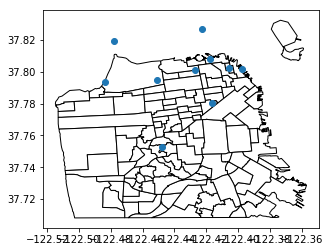

In [17]:
#plot all travel spot
scenic = pd.read_csv("data_parking/top scenic of san francisco.csv",  encoding = "ISO-8859-1")
lnglat = [geom.Point(x) for x in zip(scenic.lon, scenic.lat)]
scenic = gpd.GeoDataFrame(scenic, geometry = lnglat)
location = [(x) for x in zip(scenic.lon, scenic.lat)]
ax = sf_neighborhood.plot(edgecolor = "black", color = "white")
scenicplot = scenic.plot(ax = ax)

#routeplot.legend(loc = 'center left', bbox_to_anchor = (0.2,1.12), ncol = 3)

#for i in range(len(location)):
    
#    sf_neighborhood.annotate(scenic.iloc[i,0], xy = location[i], horizontalalignment = "center")

#### Notice:

    Since in the previous analysis, we define the recommended  parking spot within 1~2km of given travel location. Thus it's resonable for us to predict we could not find any parking spot near Golden Bridge and Alcatraz Island, since thery are on the sea and there's no way we could location any parking location within 1~2km. 

In [18]:
scenic

,viewpoint,lat,lon,geometry
0,Lovers Lane at the Presidio,37.795029,-122.451269,POINT (-122.451269 37.795029)
1,Golden Gate Bridge,37.819060,-122.478123,POINT (-122.478123 37.81906)
2,Coit Tower,37.802374,-122.405818,POINT (-122.405818 37.802374)
3,Alcatraz Island,37.826977,-122.422956,POINT (-122.422956 37.826977)
4,Baker Beach,37.793572,-122.483638,POINT (-122.483638 37.793572)
5,Twin Peaks Summit,37.752510,-122.447568,POINT (-122.447568 37.75251)
6,Lombard Street,37.801083,-122.426789,POINT (-122.426789 37.801083)
7,Fisherman's Wharf,37.808000,-122.417743,POINT (-122.417743 37.808)
8,Asian Art Museum,37.780164,-122.416199,POINT (-122.416199 37.780164)
9,Exploratorium,37.801542,-122.397484,POINT (-122.397484 37.801542)


### b.) function to plot the recommendation parking garage/lot and meter location

####  Function plot_lim Explanation:

    Take the recommended parking dataframe as input, output 4 value to set xlim and ylim .

In [19]:
def plot_lim (df):
    
    xmax = min((max(df.lon)+0.001),-122.32)
    xmin = max((min(df.lon)-0.001),-122.53)
    ymax = min((max(df.lat)+0.001),37.84)
    ymin = max((min(df.lat)-0.001),37.7)
    
    return (xmax,xmin,ymax,ymin)

##### test plot_lim function

In [20]:
xmax,xmin,ymax,ymin = plot_lim (meter_recom_test)
xmax,xmin,ymax,ymin

(-122.46425089979999, -122.4924281981, 37.7554769001, 37.7199948011)

In [21]:
place_query = {'city':'San Francisco', 'state':'California', 'country':'USA'}
G = ox.graph_from_place(place_query, network_type='drive')
nodes, edges = ox.graph_to_gdfs(G)

In [22]:
from matplotlib.pyplot import *

#### Function plot_recom_parking Explanation:

    Take the recommended parking garage and lot dataframe, travel location lontitude and latitude as input, output a map with all recommended parking garage and lot locations

In [23]:
def plot_recom_parking_gar_lot (parking_gar_lot_recom,  meter_recom, travel_lat, travel_lon, travel_location):
    xmax,xmin,ymax,ymin = plot_lim (meter_recom)
    
    #For each travel destination build a geom dataframe
    travel_one = {'lat': [travel_lat], 'lon': [travel_lon]}
    travel_one_loc = pd.DataFrame(data=travel_one)
    lnglat = [geom.Point(x) for x in zip(travel_one_loc.lon, travel_one_loc.lat)]
    travel_one_loc = gpd.GeoDataFrame(travel_one_loc, geometry = lnglat)
    
    ax = edges.plot(color = "gray", linewidth = 0.6, figsize = (16, 16))

    travel_loc_plot = travel_one_loc.plot(ax = ax, markersize = 500, color = "red", label=travel_location)
    parking_gar_lot_plot = parking_gar_lot_recom.plot(ax = ax,color = "blue", markersize = 100, label="parking garage and lot")
    meter_plot = meter_recom.plot(ax = ax, markersize = 3, label="parking meters",color = "grey")


    ax.set_xlim([xmin,xmax])
    ax.set_ylim([ymin,ymax])
    
    legend()

##### test plot_recom_parking_gar_lot function

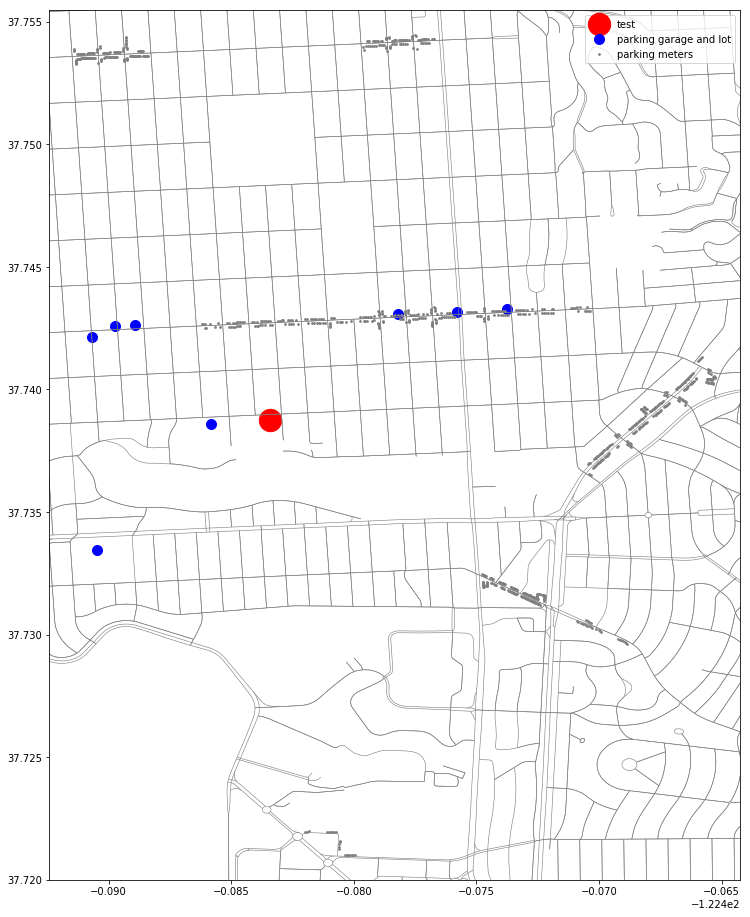

In [24]:
plot_recom_parking_gar_lot (parking_gar_lot_recom_test,  meter_recom_test, 37.738759, -122.483430,"test" )

## 4. based on meter schedule, write a time recommendation function

#### Function Explanation:

    Take meter schdule dataframe as input, and output the recommended time.

In [25]:
def meter_recom_time (meter_recom):

    meter_recom_time = meter_recom[["Post ID"]]
    meter_recom_time  = pd.merge(meter_recom_time,
                            meter_schdule_loc,
                            on='Post ID')
    meter_recom_time = meter_recom_time[["Days Applied", "From Time","To Time", "Time Limit"]]
    meter_recom_time.columns = ['days', 'from', "to","limit"]

    meter_recom_time["from"] = pd.to_datetime(meter_recom_time['from']).dt.strftime('%H:%M:%S')
    meter_recom_time["to"] = pd.to_datetime(meter_recom_time['to']).dt.strftime('%H:%M:%S')
    meter_recom_time["from"] = pd.DatetimeIndex(meter_recom_time["from"]).hour
    meter_recom_time["to"] = pd.DatetimeIndex(meter_recom_time["to"]).hour
    
    return meter_recom_time

##### test meter_recom_time function

In [26]:
meter_recom_time_test = meter_recom_time (meter_recom_test)
meter_recom_time_test.head()

,days,from,to,limit
0,"Mo,Tu,We,Th,Fr,Sa",9,18,120 minutes
1,Su,12,18,240 minutes
2,"Mo,Tu,We,Th,Fr,Sa",9,18,120 minutes
3,Su,12,18,240 minutes
4,"Mo,Tu,We,Th,Fr,Sa",9,18,120 minutes


#### Function meter_recom_time_expand Explanation:

    Take meter_recom_time dataframe as input, and output the meter_recom_time_expand dataframe.

In [27]:
def meter_recom_time_expand (meter_recom_time):
    start_time = pd.concat([pd.Series((row['from']), row['days'].split(','))              
                    for _, row in meter_recom_time.iterrows()]).reset_index()
    end_time = pd.concat([pd.Series((row['to']), row['days'].split(','))              
                    for _, row in meter_recom_time.iterrows()]).reset_index()
    time_limit = pd.concat([pd.Series((row['limit']), row['days'].split(','))              
                    for _, row in meter_recom_time.iterrows()]).reset_index()

    meter_recom_time_expand = start_time
    meter_recom_time_expand["end"] = end_time[0]
    meter_recom_time_expand["limit"] = time_limit[0]
    meter_recom_time_expand.columns = ['day', 'from', "to","limit"]
    return meter_recom_time_expand

##### test meter_recom_time_expand function

In [28]:
meter_recom_time_expand_test = meter_recom_time_expand (meter_recom_time_test)
meter_recom_time_expand_test.head()

,day,from,to,limit
0,Mo,9,18,120 minutes
1,Tu,9,18,120 minutes
2,We,9,18,120 minutes
3,Th,9,18,120 minutes
4,Fr,9,18,120 minutes


##### Function Explanation: 

    expand_hour will take a dataframe as input and output a the expanded hour frequency dataframe

In [29]:
def expand_hour(df):
    hour_full = []
    for i in df['from']: 
        end_hour = df.iloc[i-1][2]
        start_hour = df.iloc[i-1][1]
        list_regular = list(range(start_hour,end_hour+1))
    
        hour_full = hour_full + list_regular

    
    #  count the freq for each hour
    hour_freq = []
    for i in range(0,24):
        hour_freq_1 = [hour_full .count(i)]
        hour_freq = hour_freq + hour_freq_1
        
    hour_freq = pd.DataFrame(data = hour_freq, )
    hour_freq.columns = ['freq']
    
    return hour_freq

In [30]:
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns

##### Function Explanation: 

    expand_hour will take meter_recom_time_expand as input and output the week_freq dataframe

In [31]:
def week_freq (meter_recom_time_expand):
    
    #store days in a week in week list 
    week = meter_recom_time_expand.day.unique()

    week_freq = pd.DataFrame()
    #plot overlapping histogram for meter time restriction

    for i in week:
        meter_one_day = meter_recom_time_expand[meter_recom_time_expand["day"]== i].reset_index(drop=True)
        hour_freq_one_day = expand_hour(meter_one_day)
        week_freq[i] = hour_freq_one_day["freq"]
    
    return week_freq

##### test week_freq_test function

In [32]:
week_freq_test = week_freq (meter_recom_time_expand_test)
week_freq_test

,Mo,Tu,We,Th,Fr,Sa,Su
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0
9,867,867,867,867,867,867,0


#### _Notice_:
    Since the most of frequency for each hour in a day shares same values, thus plotting histogram or bar plot does not contribute anything for further analysis. 

    For example, if we want to draw bar chart for Monday's frequency we will get the following plot. 

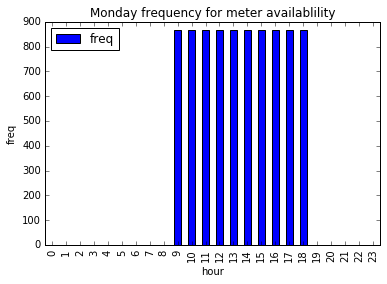

In [33]:
meter_monday = meter_recom_time_expand_test[meter_recom_time_expand_test["day"]== "Mo"].reset_index(drop=True)
hour_freq_monday = expand_hour(meter_monday)
hour_freq_monday.plot.bar()
plt.ylabel('freq')
plt.xlabel('hour')
plt.title('Monday frequency for meter availablility')
plt.show()

    If the histogram was drawn based on week_freq dataset, we will get almost same histogra all the time, since most days in a week shares the same frequency pattern through out the day. 
    
    Thus, instead of plotting an overlapping histogram plot with respect to frequencies of each day in a week,  we choose to write a function using week_freq dataframe as input,  and print out the recommendation day of week, and time of day. 

##### Function recom_day_time Explanation: 

    recom_day_time will take week_freq as input and print out the recommeded time to find meter.

In [34]:
def recom_day_time(week_freq):
    
    week_freq ["rec_time"] = week_freq.sum(axis=1)
    week_freq.loc['rec_day']= week_freq.sum()


    # set the last digit in dataframe as 0, since it's not neccesary 
    week_freq.iloc[24][7] = 0
    
    max_time_freq = week_freq.max(axis=0)[7]#return max value in rec_time column
    max_day_freq = week_freq.max(axis=1)[24]#return max value in rec_day row

    hour = np.arange(0, 25)
    print("The recommemded time of the day to find recommended meters are showing as follows")
    print(hour[week_freq["rec_time"]==max_time_freq], "( i.e. 12 means 12:00pm, 15 means 3:00pm)")
    print()
    week = np.arange(0, 8)
    max_day_freq = week_freq.max(axis=1)[24]
    print("The recommemded day of the week to find recommended meters are showing as follows")
    print(week[week_freq.iloc[-1] == max_day_freq]+1, "( i.e. 1 means Monday, 7 means Sunday)")

##### test recom_day_time function

In [35]:
recom_day_time(week_freq_test)

The recommemded time of the day to find recommended meters are showing as follows
[12 13 14 15 16 17 18] ( i.e. 12 means 12:00pm, 15 means 3:00pm)

The recommemded day of the week to find recommended meters are showing as follows
[1 2 3 4 5 6] ( i.e. 1 means Monday, 7 means Sunday)


## 5.) combine above function to generate a total parking recommendation function

#### Function Explanation:

    Take a travel destination as input, and output the recommended parking spot (including parking garage, parking lot and meters), and recommended time to find meter).

In [36]:
def recom(travel_lat, travel_lon,travel_location):
    parking_gar_lot_recom_one = parking_gar_lot_recom(parking_gar_lot,travel_lat, travel_lon)
    meter_recom_one = meter_recom(meter_schdule_loc,travel_lat, travel_lon)
    
    plot_recom_parking_gar_lot (parking_gar_lot_recom_one,  meter_recom_one, travel_lat, travel_lon,travel_location )
    
    meter_recom_time_one = meter_recom_time (meter_recom_one)
    meter_recom_time_expand_one = meter_recom_time_expand (meter_recom_time_one)
    week_freq_one = week_freq (meter_recom_time_expand_one)
    recom_day_time(week_freq_one)

##### test recom function

The recommemded time of the day to find recommended meters are showing as follows
[12 13 14 15 16 17 18] ( i.e. 12 means 12:00pm, 15 means 3:00pm)

The recommemded day of the week to find recommended meters are showing as follows
[1 2 3 4 5 6] ( i.e. 1 means Monday, 7 means Sunday)


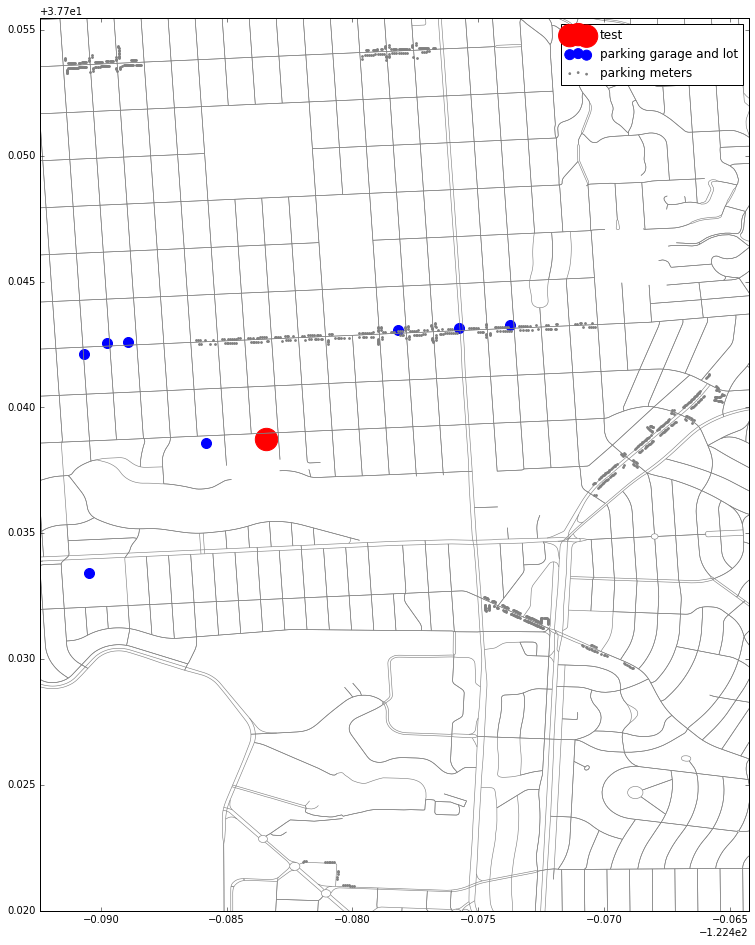

In [37]:
recom(37.738759, -122.483430,"test")

## 6.) generate parking suggestion for travel places in scenic file. 

In [38]:
scenic

,viewpoint,lat,lon,geometry
0,Lovers Lane at the Presidio,37.795029,-122.451269,POINT (-122.451269 37.795029)
1,Golden Gate Bridge,37.819060,-122.478123,POINT (-122.478123 37.81906)
2,Coit Tower,37.802374,-122.405818,POINT (-122.405818 37.802374)
3,Alcatraz Island,37.826977,-122.422956,POINT (-122.422956 37.826977)
4,Baker Beach,37.793572,-122.483638,POINT (-122.483638 37.793572)
5,Twin Peaks Summit,37.752510,-122.447568,POINT (-122.447568 37.75251)
6,Lombard Street,37.801083,-122.426789,POINT (-122.426789 37.801083)
7,Fisherman's Wharf,37.808000,-122.417743,POINT (-122.417743 37.808)
8,Asian Art Museum,37.780164,-122.416199,POINT (-122.416199 37.780164)
9,Exploratorium,37.801542,-122.397484,POINT (-122.397484 37.801542)


In [39]:
def parking_recommendation (viewpoint, lat, lon):
    
    print("Parking analysis for " + viewpoint)
    print()
    try: 
        recom(lat, lon,viewpoint)
        
    except:
        print("no parking recommendation for " + viewpoint)
        
    print()
    print()
    print()
        
    return 

##### test parking_recommendation function

Parking analysis for Lovers Lane at the Presidio

The recommemded time of the day to find recommended meters are showing as follows
[12 13 14 15 16 17 18] ( i.e. 12 means 12:00pm, 15 means 3:00pm)

The recommemded day of the week to find recommended meters are showing as follows
[1 2 3 4 5 6] ( i.e. 1 means Monday, 7 means Sunday)





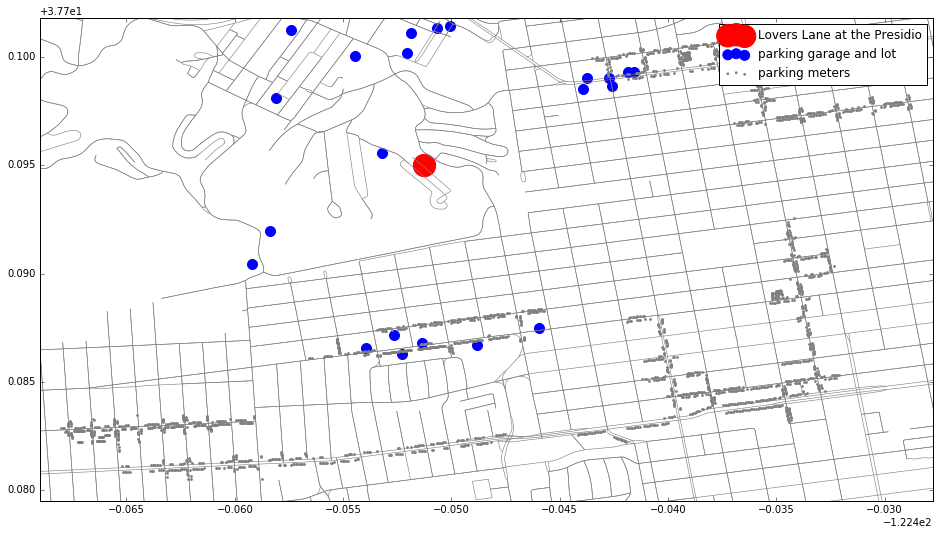

In [40]:
parking_recommendation ("Lovers Lane at the Presidio",37.795029,-122.451269)

Parking analysis for Lovers Lane at the Presidio

The recommemded time of the day to find recommended meters are showing as follows
[12 13 14 15 16 17 18] ( i.e. 12 means 12:00pm, 15 means 3:00pm)

The recommemded day of the week to find recommended meters are showing as follows
[1 2 3 4 5 6] ( i.e. 1 means Monday, 7 means Sunday)






Parking analysis for Golden Gate Bridge

no parking recommendation for Golden Gate Bridge






Parking analysis for Coit Tower

The recommemded time of the day to find recommended meters are showing as follows
[12 13 14 15 16 17 18] ( i.e. 12 means 12:00pm, 15 means 3:00pm)

The recommemded day of the week to find recommended meters are showing as follows
[1 2 3 4 5 6] ( i.e. 1 means Monday, 7 means Sunday)






Parking analysis for Alcatraz Island

no parking recommendation for Alcatraz Island






Parking analysis for Baker Beach

The recommemded time of the day to find recommended meters are showing as follows
[12 13 14 15 16 17 18] ( i.e. 12 mean

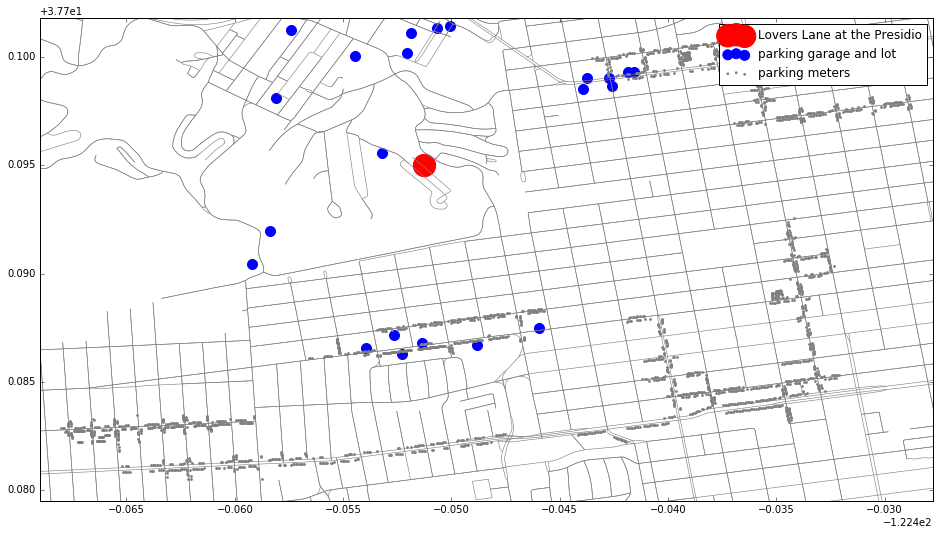

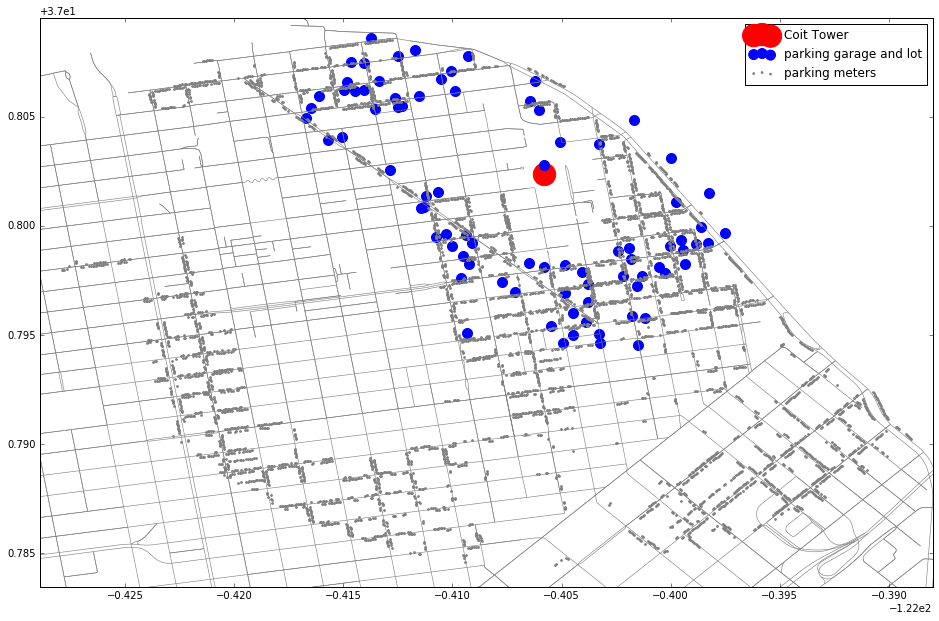

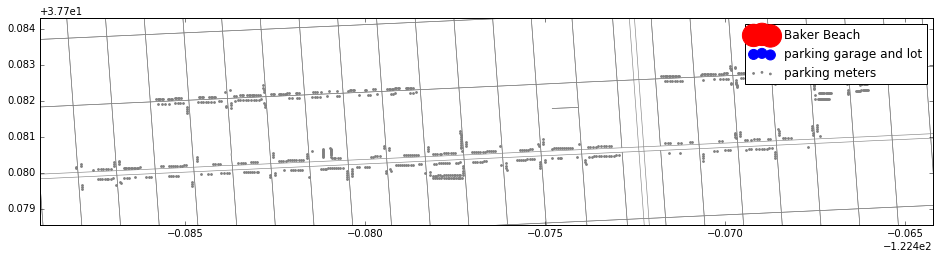

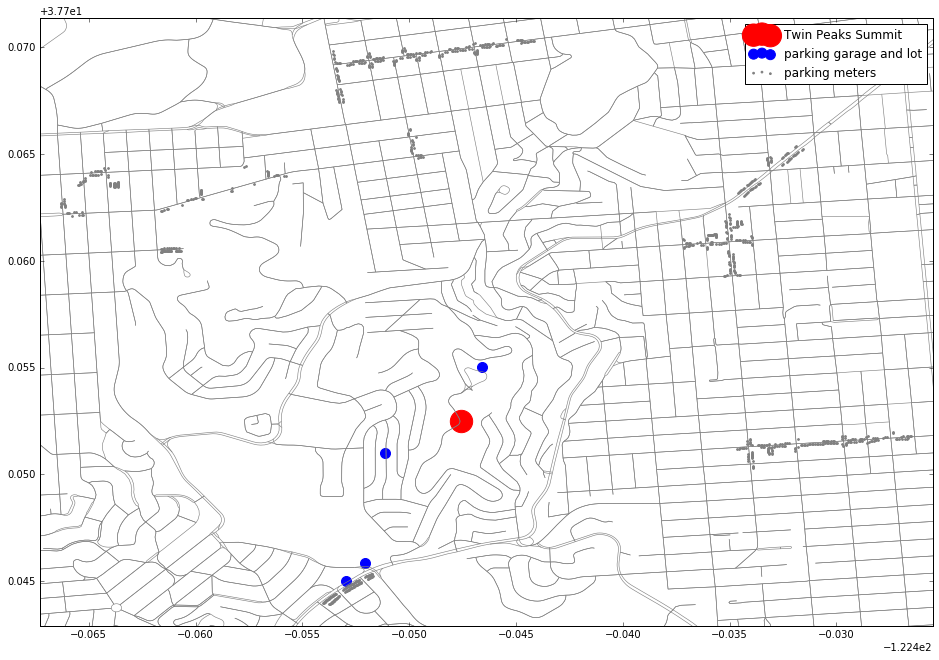

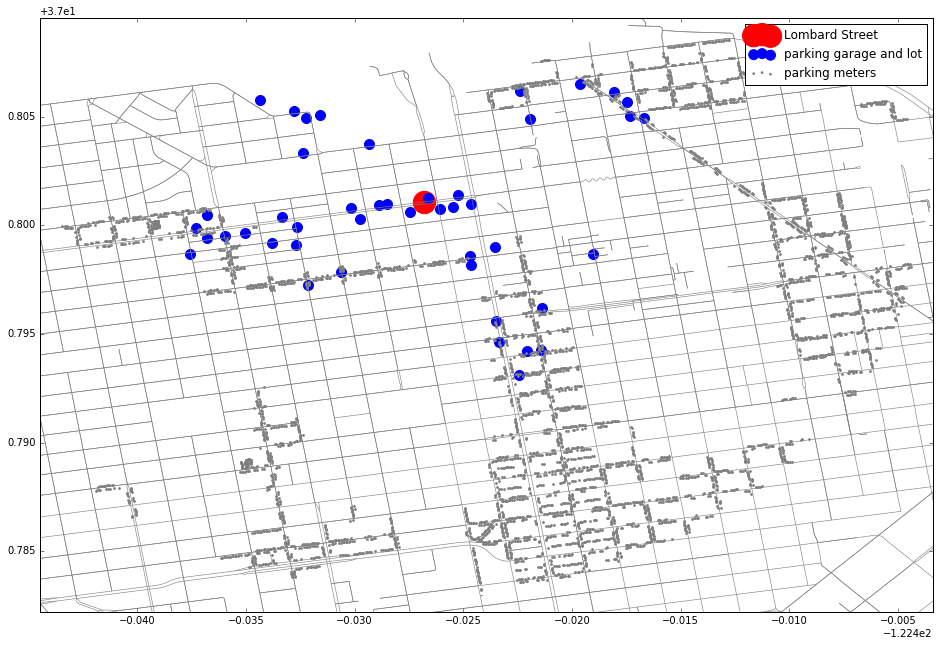

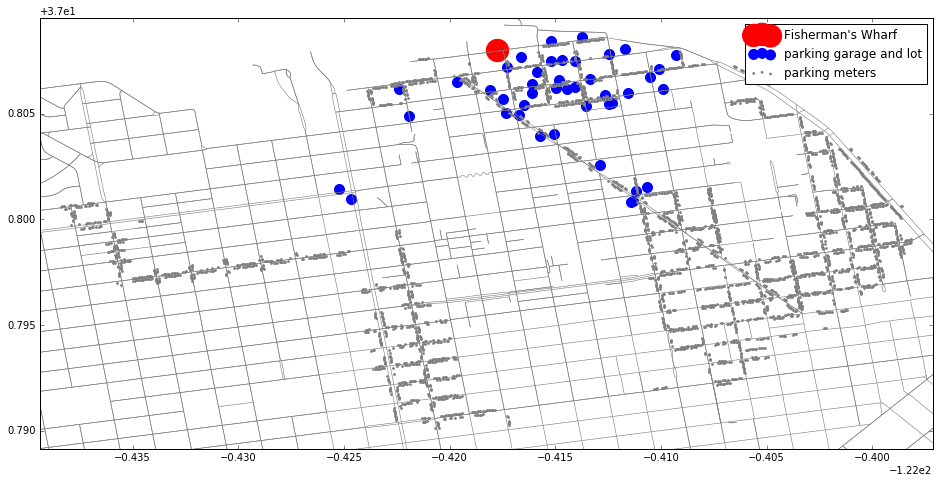

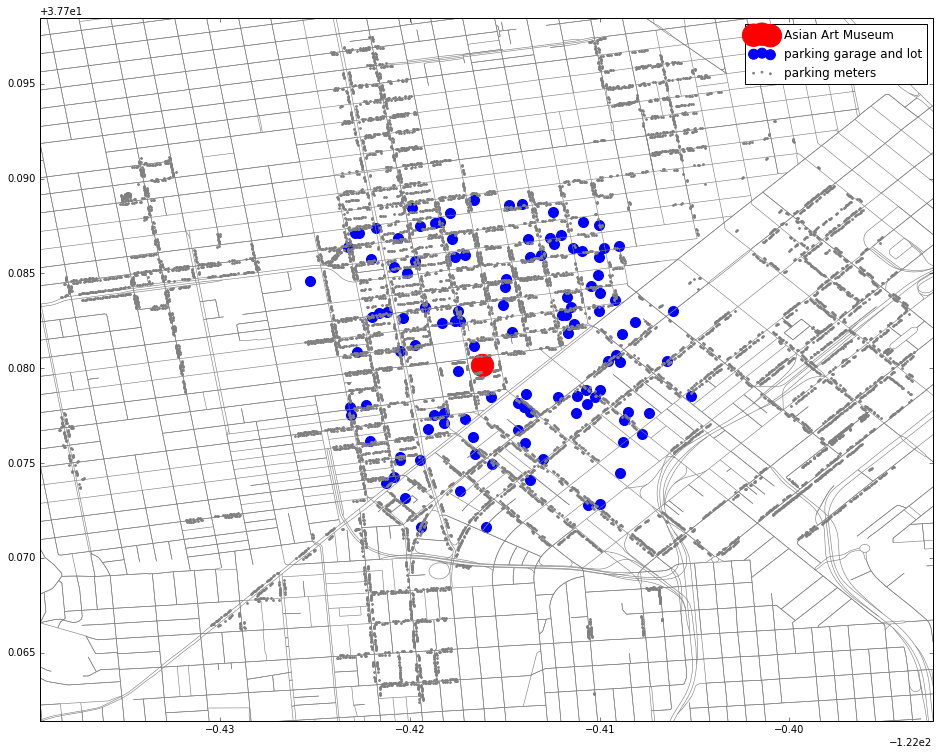

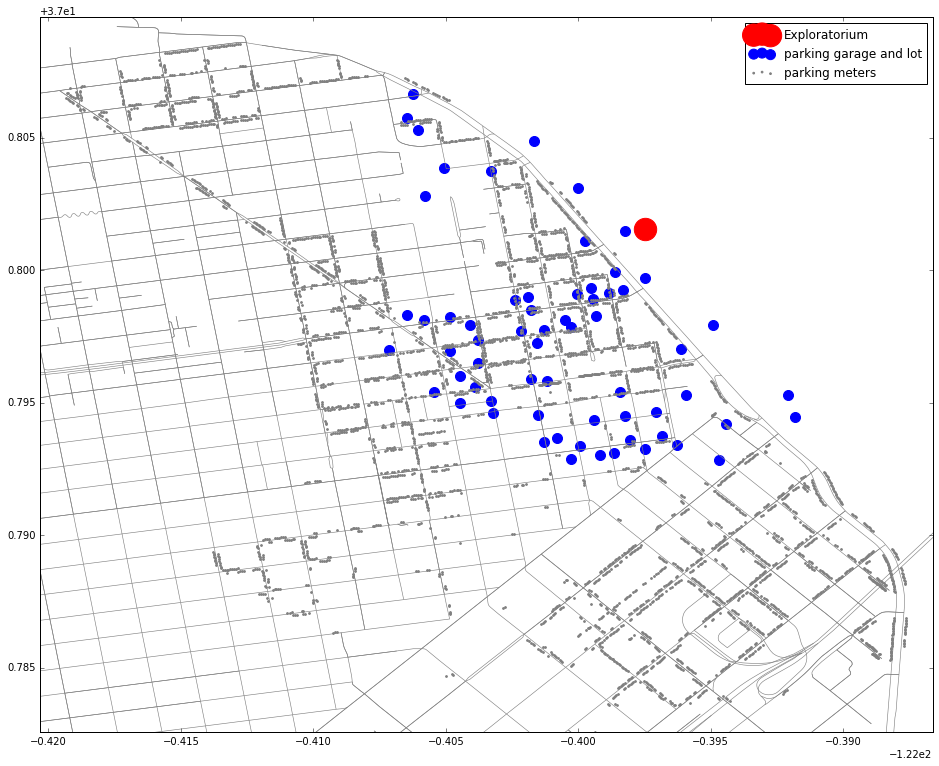

In [41]:
a,b = scenic.shape

for i in range(0,a):
    
    travel_location = scenic["viewpoint"][i]
    travel_lat = scenic["lat"][i]
    travel_lon = scenic["lon"][i]
    
    parking_recommendation (travel_location, travel_lat, travel_lon)
    
    print()
    print()
    print()

## Final Analysis for Parking 
    1.)
    The recommended parking garage and parking lot are within 1km distance from the travel location, while as the meters are within 2km. Since one garage ot parking lot location may have multiple parking spots, and one meter location only have one parking spot, by expanding range for meter location may help us to get relatively equal amount of parking spots for garage/lot and meter.
    
    Moreover, garage and parking lot fee may be extremly expensive in San Francisco, thus more information for meters may be favored by tourist due to budget consideration. 
    
    2.)
    Notice that we could not find any information for Golden Gate Bridge and Alcatraz Island, which corresponds to the previous postulation. 
    
    Based on this fact, we might suggest the traveler to park somewhere else rather than location near to those two travel destinations. 
    
    3.)
    For 
    